#1 Author

Student Name: Pradnya Gade

Student ID: 210059058

# 2 Problem formulation

Problem :
Using the MLEnd Hums and Whistles dataset, build a machine learning pipeline that takes all the eight songs as input audio segment and predicts its song label.

Two approaches:
1. Supervised :
As a part of this problem, we are provided with the information such as the Participant id ,interpretation type (hum/whistle), interpretation number(1-4) for each participant and the name of song(Harry/StarWars/Panther/Rain/Hakuna/Frozen/Mamma/Showman) . Using this information, we have to predict the song label.

2. Unsupervised:
As a part of this problem, only the files are provided with no labels and the song is predicted.



# 3 Machine Learning pipeline

I would like to define my pipeline for the supervised approach as:

Pipeline consists of below mentioned stages

1. Create new features columns
2. Perform required data preprocessing and feature scaling
3. Build a model to predict the song

For the unsupervised approach, the labels are not taken into consideration only the features form different clusters to predict the song.

Loading useful Python libraries and mounting my personal Google Drive storage system

In [12]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

from sklearn import preprocessing

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4 Transformation stage

At this stage I have listed down the set of features and necessary preprocessing steps (for each of them) to be used in the machine learning pipeline.

1.   Pitch
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.
5.   Zero crossings rate : It can be defined as the number of times the signal changes value, from positive to negative and vice versa, divided by the length of the frame.It can be defined as a measure of the noisiness of a signal.This spectral characteristic showcases higher values in the case of noisy signals.
6.   Tempo : Tempo is the speed or pace at which a exhibit of music is played. The tempo can have any quantity of beats per minute. The lower the number of beats per minute, the slower the tempo. Inversely, the higher the number of beats per minute, the tempo will be faster. The portion of the audio which do not showcase salient harmonic progression may be frequently better characterized using tempo patterns.

For all the files these ablove six features are extracted with the help of getPitch and getXy function defined below.

In [19]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [20]:
def getfeatures(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X=[]
  y=[]
  for file in tqdm(files):
    
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)

    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    zero_crossings = librosa.zero_crossings(x[9000:9100], pad=False)
    onset_env = librosa.onset.onset_strength(x, sr=fs)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=fs)


    xi = [power,pitch_mean,pitch_std,voiced_fr,sum(zero_crossings),tempo[0]]
    fileID = preProcess(file).split('/')[-1].strip().lower()
    yi = labels_file.loc[fileID]['song']

    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

y will values as for each label ["Frozen":0, "Hakuna":1, "Mamma":2, "Panther":3,Potter":4, "Rain":5, "Showman":6, "Starwars":7]

Extracting all the six features for the files:

In [21]:
X,y = getfeatures(files, labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 1673/1673 [1:36:27<00:00,  3.46s/it]


Normalizing the data:
Scaling and translating each feature individually such that it is in the range of (-1,1). 

In [22]:
import sklearn
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(X)

Splitting the files into training, validation and testing.
I will train all the models on the training data and check it’s performance on the validation data. 

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features_scaled,y,test_size=0.3,random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1171, 6), (502, 6), (1171,), (502,))

# 5 Modelling

ML supervised models implemented : 

1. Logistic Regression 
2. Naive Bayes
3. Random Forrest
4. Support Vector Machine

Unsupervised model implemented:
1. K means 

# 6 Methodology

Train and validation sets are ready. Let us train all the models on training data and check it’s performance on the validation data.
Calculated training and validation accuracy for all the models.Comparing the validation accuracy to arrive at the highest performing model.

In [24]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression

# Here we fit our logistic regression classfier to the training dataset 
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train,y_train)

yt_p = log_reg_classifier.predict(X_train)
yv_p = log_reg_classifier.predict(X_val)

print('Training Accuracy',log_reg_classifier.score(X_train,y_train))
print('Validation  Accuracy', log_reg_classifier.score(X_val,y_val))


Training Accuracy 0.3296327924850555
Validation  Accuracy 0.2868525896414343


In [25]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb_A = GaussianNB()
gnb_A.fit(X_train,y_train)

yt_p = gnb_A.predict(X_train)
yv_p = gnb_A.predict(X_val)

print('Training Accuracy',gnb_A.score(X_train,y_train))
print('Validation  Accuracy',gnb_A.score(X_val,y_val))

Training Accuracy 0.3552519214346712
Validation  Accuracy 0.3466135458167331


In [27]:
#SVM
from sklearn import svm

model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.41246797608881297
Validation  Accuracy 0.34860557768924305
The support vectors are (1161, 6)


Trying out different values for the hyperparamater.

In [28]:
#SVM with C=4
from sklearn import svm

model  = svm.SVC(C=4)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.46199829205807
Validation  Accuracy 0.3665338645418327
The support vectors are (1131, 6)


In [29]:
#SVM with C=2
from sklearn import svm

model  = svm.SVC(C=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.4363791631084543
Validation  Accuracy 0.37250996015936255
The support vectors are (1149, 6)


The best validation accuracy is obtained for Random Forrest algorithm in comparision with all the other models

In [26]:
#Random Forrest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)

yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)

print('Training Accuracy',clf.score(X_train,y_train))
print('Validation  Accuracy',clf.score(X_val,y_val))

Training Accuracy 0.4022203245089667
Validation  Accuracy 0.37649402390438247


In [30]:
from sklearn.metrics import classification_report
print(classification_report(yv_p,y_val))

              precision    recall  f1-score   support

           0       0.51      0.30      0.38        90
           1       0.35      0.38      0.36        48
           2       0.73      0.50      0.60       101
           3       0.39      0.38      0.38        74
           4       0.12      0.22      0.15        27
           5       0.21      0.35      0.26        43
           6       0.19      0.27      0.22        45
           7       0.44      0.41      0.42        74

    accuracy                           0.37       502
   macro avg       0.37      0.35      0.35       502
weighted avg       0.43      0.37      0.39       502



In [31]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_heatmap(y_validation, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_validation))   # get the labels in the y_test
   
    cm = confusion_matrix(y_validation, preds) #, labels
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=15)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
   
    plt.show()

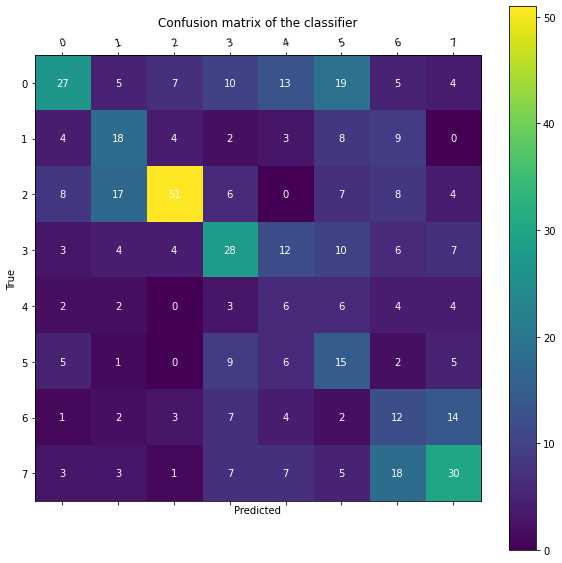

In [32]:
confusion_matrix_heatmap(yv_p,y_val)

The most correctly predicted song label is Mamma, its predicted correctly 51 times.
The most incorrectly predicted song label is Frozen, it is incorrectly predicted as Rain

Clustering:

Creating eight clusters using K means, using only the scaled features of the files.

In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8)
yi = kmeans.fit_predict(features_scaled)
yi


array([1, 3, 1, ..., 1, 4, 4], dtype=int32)

8 clusters are incorrectly formed(not dependent on the song labels)

In [52]:
temp = MLENDHW_df.head(1673)
temp['cluster'] = yi
temp.head(250)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,participant,interpretation,interpretation number,song,cluster
file_id,,,,,
s103_whistle_2_potter.wav,S103,whistle,2,4,6
s103_hum_2_potter.wav,S103,hum,2,4,4
s40_whistle_2_potter.wav,S40,whistle,2,4,0
s40_hum_2_potter.wav,S40,hum,2,4,4
s17_hum_1_potter.wav,S17,hum,1,4,7
...,...,...,...,...,...
s36_hum_2_panther.wav,S36,hum,2,3,2
s28_hum_2_panther.wav,S28,hum,2,3,2
s32_hum_2_panther.wav,S32,hum,2,3,4


# 7 Dataset

Dataset includes data from eight folders ['Potter_1', 'StarWars_1','Panther_1','Rain_1','Hakuna_1','Frozen_1','Mamma_1','Showman_1'] containing 1673 files extracted from personal Google Drive storage system.

In [13]:
path = '/content/drive/MyDrive/Data/Advanced'
os.listdir(path)

['Panther_1',
 'Rain_1',
 'Hakuna_1',
 'Frozen_1',
 'Mamma_1',
 'Showman_1',
 'Potter_1',
 'Potter_2',
 'StarWars_1',
 'StarWars_2']

In [14]:
potter_1_path = '/content/drive/MyDrive/Data/Advanced/Potter_1/*.wav'
panther_1_path = '/content/drive/MyDrive/Data/Advanced/Panther_1/*.wav'
rain_1_path = '/content/drive/MyDrive/Data/Advanced/Rain_1/*.wav'
hakuna_1_path = '/content/drive/MyDrive/Data/Advanced/Hakuna_1/*.wav'
frozen_1_path = '/content/drive/MyDrive/Data/Advanced/Frozen_1/*.wav'
mamma_1_path = '/content/drive/MyDrive/Data/Advanced/Mamma_1/*.wav'
showman_1_path = '/content/drive/MyDrive/Data/Advanced/Showman_1/*.wav'
starwars_1_path = '/content/drive/MyDrive/Data/Advanced/StarWars_1/*.wav'

files = glob.glob(potter_1_path)
files.extend(glob.glob(panther_1_path))
files.extend(glob.glob(rain_1_path))
files.extend(glob.glob(hakuna_1_path))
files.extend(glob.glob(frozen_1_path))
files.extend(glob.glob(mamma_1_path))
files.extend(glob.glob(showman_1_path))
files.extend(glob.glob(starwars_1_path))

len(files)

1673

Pre process function that takes each file and corrects the file name

In [15]:
def preProcess(file):
  
  file = file.replace("[", "")
  file = file.replace("]", "")
  file = file.replace(" ", "_")
  file = file.replace(".", "_")
  file = '.'.join(file.rsplit('_', 1))
  return file

In [51]:
for file in files:
  file=preProcess(file)
  try:
    song = file.split('/')[-1].split('_')[3].split('.')[0].lower()
    interpretation = file.split('/')[-1].split('_')[1].lower()
    if song!= "potter" and song!="starwars":
      print("File:",file.split('/')[-1])
    if interpretation!="hum" and interpretation!="whistle":
      print("File:",file.split('/')[-1])   
  except:
    print("File:",file.split('/')[-1])

File: S38_hum_3_Potterwav.wav
File: S105_hum_1_harry_potter.wav
File: S55_harrypotter_hum_2.wav
File: S55_harrypotter_hum_2.wav
File: S55_harrypotter_whistle_1.wav
File: S55_harrypotter_whistle_1.wav
File: S146_hum_3_(potter).wav
File: S146_hum_1_(potter).wav
File: S138_whistle_1_Harry_Potter_Theme_Song.wav
File: S138_hum_1_Harry_Potter_Theme_Song.wav
File: S61_hum_2_StatWars.wav
File: S102_whistle_1_Star_wars.wav
File: S102_whistle_2_Star_wars.wav
File: S85_hum_3_StarsWars.wav
File: S85_hum_4_StarsWars.wav
File: S55_starwars_hum_1.wav
File: S55_starwars_hum_1.wav
File: S49_hum_2__Star_Wars_.wav
File: S55_starwars_whistle_2.wav
File: S55_starwars_whistle_2.wav
File: S49_hum_3__Star_Wars_.wav
File: S6_whisle_1_starwar.wav
File: S6_whisle_1_starwar.wav
File: S114_hum_3_star_wars.wav
File: S114_hum_4_star_wars.wav
File: S6_whisle_2_starwar.wav
File: S6_whisle_2_starwar.wav
File: S221_hum_1_StartWars.wav
File: S150_hum_1_imperial_march.wav
File: S141_hum2_Imperial_March.wav
File: S141_hum2

In [8]:
for file in files:
  file=preProcess(file)
  try:
    song = file.split('/')[-1].split('_')[3].split('.')[0].lower()
    interpretation = file.split('/')[-1].split('_')[1].lower()
    if song!= "potter" and song!="starwars" and song!="rain" and song!="hakuna" and song!="frozen" and song!="mamma" and song!="showman" and song!="panther":
      print("File:",file.split('/')[-1])
    if interpretation!="hum" and interpretation!="whistle":
      print("File:",file.split('/')[-1])   
  except:
    print("File:",file.split('/')[-1])

File: S35_hum_1__Panther.wav
File: S47_hum_1_pinkpanther.wav
File: S47_whistle_1_pinkpanther.wav
File: S5_hum_1_PinkPanther.wav
File: S5_hum_4_PinkPanther.wav
File: S105_hum_1_pink_panther.wav
File: S105_whistle_2_pink_panther.wav
File: S42_Hum3_Pink_Panther_wav.wav
File: S49_hum_1___Panther_.wav
File: S49_hum_3__Panther_.wav
File: S55_pinkpanther_hum_2.wav
File: S55_pinkpanther_hum_2.wav
File: S55_pinkpanther_whistle_2.wav
File: S55_pinkpanther_whistle_2.wav
File: S6_whisle_2_rain.wav
File: S105_hum_1_singing_in_the_rain.wav
File: S105_hum_2_singing_in_the_rain.wav
File: S55_singingintherain_whistle_1.wav
File: S55_singingintherain_whistle_1.wav
File: S55_singingintherain_whistle_2.wav
File: S55_singingintherain_whistle_2.wav
File: S82_hum_2_Rainwav.wav
File: S49_hum_4__Rain_.wav
File: S49_hum_1__Rain_.wav
File: S42_Hum2_The_Rain_wav.wav
File: S49_hum_3__Hakuna_.wav
File: S49_hum_1__Hakuna_.wav
File: S5_hum_2_HakunaMatata.wav
File: S5_hum_3_HakunaMatata.wav
File: S42_Hum3_Hakuna.wav
F

After correcting the above detected errors manually creating a dataframe below.

In [49]:
from sklearn import preprocessing

MLENDHW_table = [] 

for file in files:
  file = preProcess(file)
  file_name = file.split('/')[-1].strip().lower()
  participant_ID = file.split('/')[-1].split('_')[0]
  interpretation_type = file.split('/')[-1].split('_')[1].lower()
  interpretation_number = file.split('/')[-1].split('_')[2]
  song = file.split('/')[-1].split('_')[3].split('.')[0].lower()
  MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number,song])

MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','interpretation number','song']).set_index('file_id') 

#Label Encoding song name column
le = preprocessing.LabelEncoder()
MLENDHW_df['song'] = le.fit_transform(MLENDHW_df.song.values)
MLENDHW_df


,participant,interpretation,interpretation number,song
file_id,,,,
s103_whistle_2_potter.wav,S103,whistle,2,4
s103_hum_2_potter.wav,S103,hum,2,4
s40_whistle_2_potter.wav,S40,whistle,2,4
s40_hum_2_potter.wav,S40,hum,2,4
s17_hum_1_potter.wav,S17,hum,1,4
...,...,...,...,...
s49_hum_2_starwars.wav,S49,hum,2,7
s6_whistle_2_starwars.wav,S6,whistle,2,7
s6_whistle_1_starwars.wav,S6,whistle,1,7


Songs are labelled as: ["Frozen":0, "Hakuna":1, "Mamma":2, "Panther":3,Potter":4, "Rain":5, "Showman":6, "Starwars":7]

# 8 Results

Experimentation with Clustering:

Trying to check for patterns with two clusters, but they turn out inappropriate as expected clusters for hum/whistle depending on the pitch features.

In [53]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
yi = kmeans.fit_predict(features_scaled)
yi

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [54]:
temp = MLENDHW_df.head(1673)
temp['cluster'] = yi
temp.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,participant,interpretation,interpretation number,song,cluster
file_id,,,,,
s103_whistle_2_potter.wav,S103,whistle,2,4,0
s103_hum_2_potter.wav,S103,hum,2,4,0
s40_whistle_2_potter.wav,S40,whistle,2,4,0
s40_hum_2_potter.wav,S40,hum,2,4,0
s17_hum_1_potter.wav,S17,hum,1,4,0
s17_hum_2_potter.wav,S17,hum,2,4,0
s16_hum_2_potter.wav,S16,hum,2,4,0
s115_hum_2_potter.wav,S115,hum,2,4,0
s16_whistle_2_potter.wav,S16,whistle,2,4,0


Experimentation with different features.

Explored other features such as : 
1. Spectral Centroid 

Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

2. Spectral Roll-off

The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. 

3. MFCC

Mel-frequency cepstral coefficients 

Drawback :     
All of these features gave the characteristics of the audio in an array, which was difficult to import as a feature value.

In [70]:
#Spectral Centroid
y, sr = librosa.load(files[0])
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
cent

array([[7538.97241152, 4232.7004824 , 3696.2080859 , 3642.18183005,
        3646.24892707, 3837.83385017, 4124.2550012 , 4325.56455081,
        4213.5707724 , 4263.99772883, 4144.7374888 , 4029.67756727,
        4208.16219804, 4172.80290504, 3958.45742034, 4249.9002293 ,
        3383.12731936, 2388.15508845, 2100.9863134 , 2008.35328477,
        2039.43734395, 2071.76244997, 2190.73081112, 2127.99786486,
        1938.08936921, 1675.56087538, 1340.0276418 , 1337.55449424,
        1365.95494864, 1524.9534736 , 1704.496551  , 1752.80635341,
        1835.40488313, 1845.46252985, 1814.80170714, 1871.42714372,
        1812.1774551 , 1755.98875926, 1721.4972958 , 1654.73474583,
        1615.3013553 , 1597.29404633, 1453.24934323, 1344.42532437,
        1337.99958002, 1213.43474709, 1227.54756303, 1565.05234245,
        1630.71175401, 1677.54784234, 1697.97462348, 1583.64521989,
        1585.85823757, 1672.14874684, 1647.04225751, 1576.19973464,
        1542.33359111, 1538.22553224, 1575.08724

In [71]:
#Spectral Rolloff
librosa.feature.spectral_rolloff(y=y, sr=sr)

array([[9754.54101562, 7062.890625  , 6136.96289062, 6083.12988281,
        6093.89648438, 6233.86230469, 6341.52832031, 6438.42773438,
        6449.19433594, 6503.02734375, 6438.42773438, 6384.59472656,
        6427.66113281, 6406.12792969, 6373.828125  , 6459.9609375 ,
        6255.39550781, 5361.76757812, 4597.33886719, 3789.84375   ,
        3606.81152344, 3552.97851562, 3865.20996094, 3682.17773438,
        3186.9140625 , 2390.18554688, 1647.29003906, 1625.75683594,
        1765.72265625, 2056.42089844, 2368.65234375, 2454.78515625,
        2573.21777344, 2583.984375  , 2551.68457031, 2605.51757812,
        2519.38476562, 2411.71875   , 2422.48535156, 2368.65234375,
        2347.11914062, 2207.15332031, 1851.85546875, 1518.09082031,
        1464.2578125 , 1485.79101562, 1819.55566406, 1722.65625   ,
        1701.12304688, 1754.95605469, 1905.68847656, 1593.45703125,
        1679.58984375, 1841.08886719, 1754.95605469, 1614.99023438,
        1561.15722656, 1636.5234375 , 1571.92382

In [72]:
#MFCC
librosa.feature.mfcc(y=y, sr=sr)

array([[-5.73890625e+02, -5.73890625e+02, -5.71185608e+02, ...,
        -5.73890625e+02, -5.73874634e+02, -5.73890625e+02],
       [ 0.00000000e+00,  0.00000000e+00,  3.04466534e+00, ...,
         0.00000000e+00,  2.20025312e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.12246084e+00, ...,
         0.00000000e+00,  2.02006474e-02,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -2.12775826e+00, ...,
         0.00000000e+00, -1.53915221e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.17721009e+00, ...,
         0.00000000e+00, -1.11470055e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.14677548e+00, ...,
         0.00000000e+00, -6.29868871e-03,  0.00000000e+00]], dtype=float32)

# 9 Conclusions

Normalisation: Scaling the features to a range of (-1, 1 ) showed major improvement in the accuracy.

Feature Selection for supervised: Tempo feature included also helped in drastically improving the accuracy of the model implying that both Potter and Starwars can be distinguished based on the tempo.

The best model was random forrest, it gave an validation accuracy of 0.37.

The unsupervised K means algorithm did not work, It would require more study of audio features for appropriate feature selection in order to form correct clusters. 